## IS608 - Assignment # 4 - Data Visualization in Python

James Hamski 

This assignment visualizes measurements of Enterococcus levels in the Hudson River, using data from the organization Riverkeeper (http://www.riverkeeper.org/). 

#### Notebook Setup and Module Import

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


I used a "non-standard" module called *qgrid* to provide an interactive table. 

In [2]:
# https://github.com/quantopian/qgrid
import qgrid
qgrid.nbinstall(overwrite=True)

#### Data Import and Tidying

In [3]:
data_url = "https://raw.githubusercontent.com/jlaurito/CUNY_IS608/master/lecture4/data/riverkeeper_data_2013.csv"
raw_RiverKeeper_data = pd.read_csv(data_url)

In [4]:
raw_RiverKeeper_data.head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,10/16/2011,1733,1.5,35
1,Hudson above Mohawk River,10/21/2013,4,0.2,35
2,Hudson above Mohawk River,9/21/2013,20,0.0,35
3,Hudson above Mohawk River,8/19/2013,6,0.0,35
4,Hudson above Mohawk River,7/21/2013,31,0.0,35


In [5]:
raw_RiverKeeper_data.describe()

,FourDayRainTotal,SampleCount
count,3397.000000,3397.000000
mean,0.568001,56.886370
std,1.000387,41.588476
min,0.000000,27.000000
25%,0.000000,37.000000
50%,0.200000,42.000000
75%,0.700000,50.000000
max,8.500000,187.000000


In [6]:
raw_RiverKeeper_data.dtypes

Site                 object
Date                 object
EnteroCount          object
FourDayRainTotal    float64
SampleCount           int64
dtype: object

The first step is to get Site into a category type, Date into the date type, and EnteroCount, FourDayRainTotal, and SampleCount into their proper numeric types. 

In [7]:
rk = raw_RiverKeeper_data

*Site*

In [8]:
rk["Site"] = rk["Site"].astype('category')

*Date*

In [9]:
rk["Date"] = pd.to_datetime(rk["Date"])

*EnteroCount*
Enterococcus counts include indicators that some measurements exceeded the maximum measurable level and were below the miniumum measurable level. Like measurement error, handeling this situation is context driven and must be handled in the most truthful way possible. From the data source: *The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100mL.*

The maximum reading is 2420 cells per 100 mL, signified by ">2420". This is over an order of magnitude higher than the water quality criterion, therefore how we handle extremely high limits should not have a significant effect of decision making. I am going to round the readings that exceed the maximum measurement to 2420. 

The minimum reading is sometimes 10 cells per 100 mL, signified by < 10, and sometimes 1 cell per 100 mL, signified by < 1. This situation has a lot of potential to create misleading graphics when comparing sites with low entero concentrations. However, in the context of the water quality criterion above, by rounding the measurements up to 10 and 1, respectively, we are taking the most 

The EPA most likely has specific guidance on how to handle measurement precision for Enterococcus, which would be the best way to decide what to do here. 

In [10]:
rk["EnteroCount"] = rk["EnteroCount"].str.lstrip('><')

In [11]:
rk["EnteroCount"] = rk["EnteroCount"].astype('int64')

In [12]:
rk.dtypes

Site                      category
Date                datetime64[ns]
EnteroCount                  int64
FourDayRainTotal           float64
SampleCount                  int64
dtype: object

#### 1. Create lists & graphs of the best and worst places to swim in the dataset.

##### Graph

I'll first take a look at the median Enterococcus counts at each site, in descending order. 

In [13]:
site_med = rk.groupby('Site', as_index=False).median()
site_med = site_med.sort_values(by='EnteroCount', ascending=False)

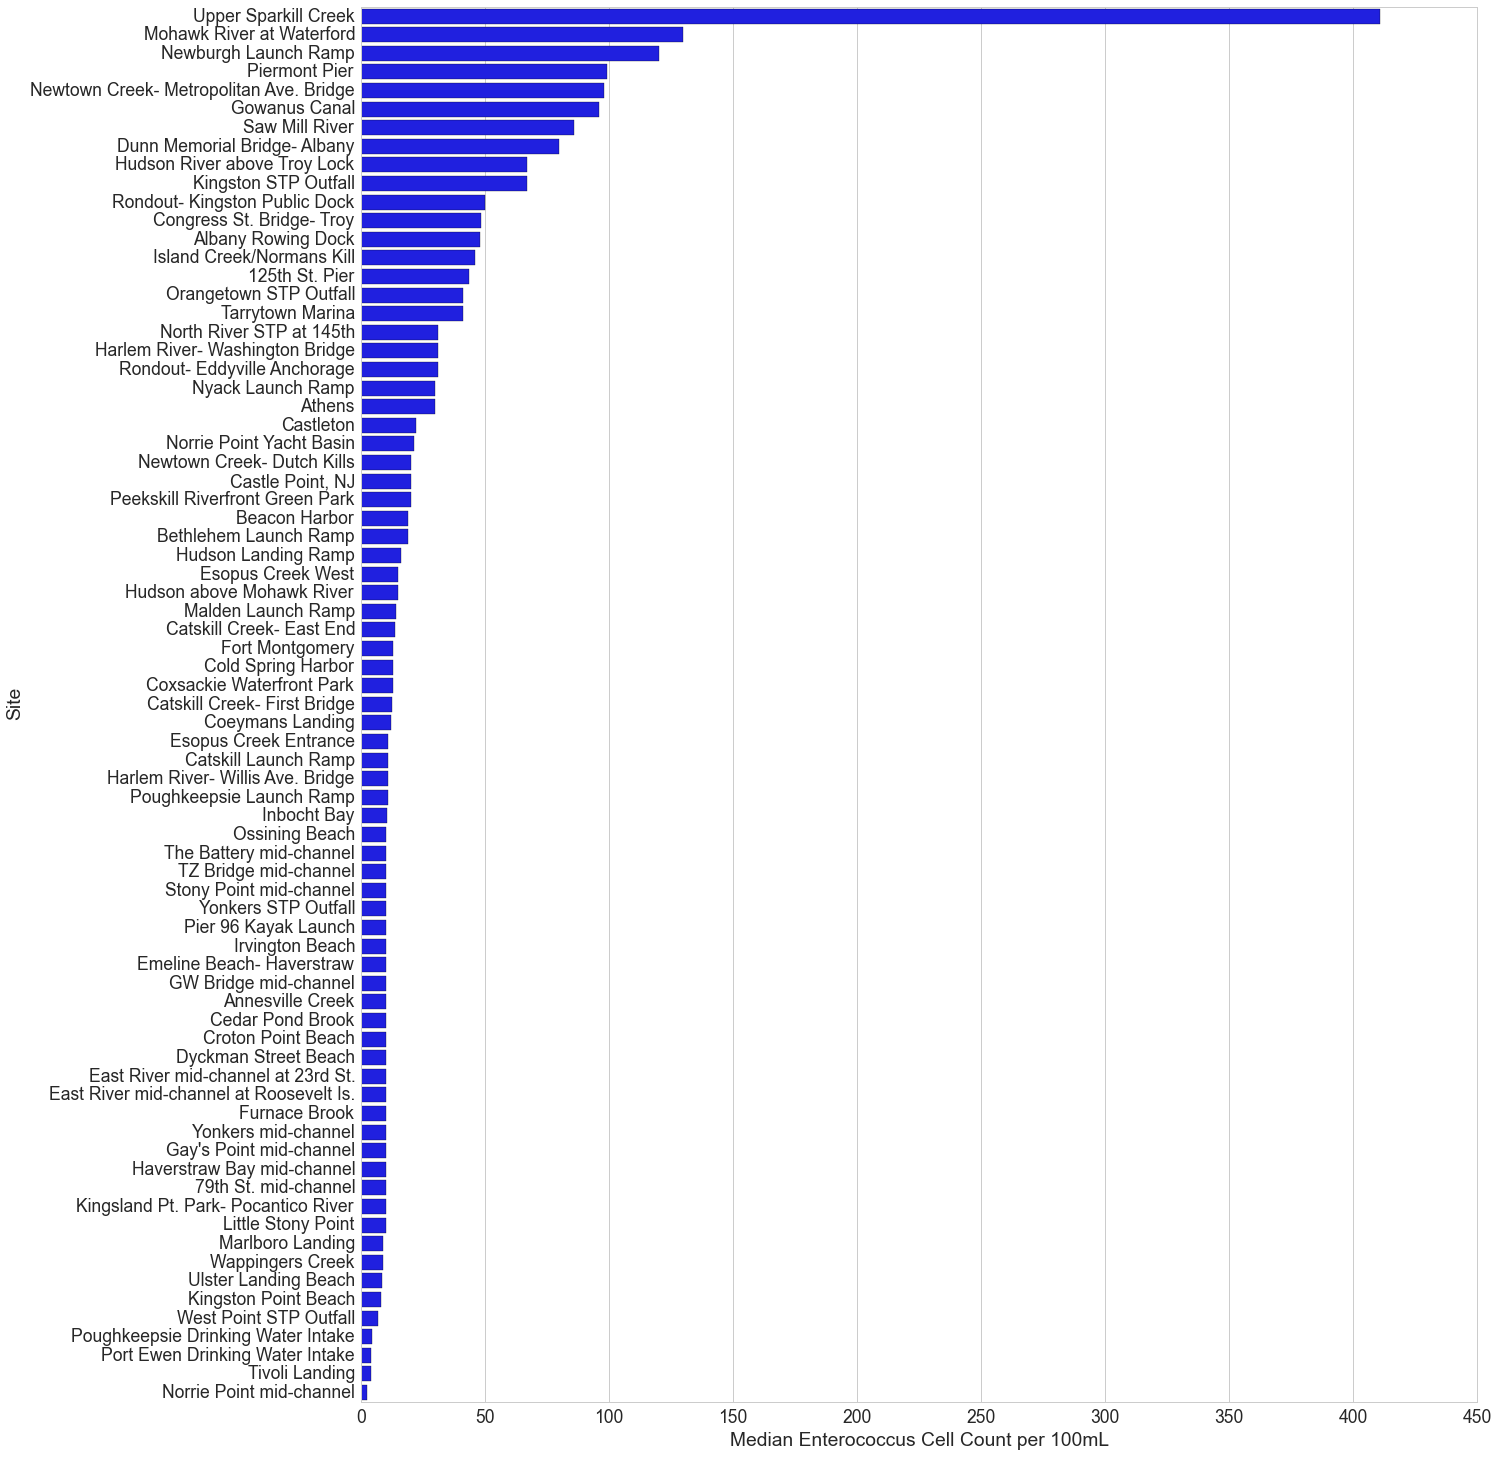

In [14]:
plt.figure(figsize=(20, 25))
sns.set(font_scale=1.75, style='whitegrid')

g1 = sns.barplot(x='EnteroCount', y='Site', data=site_med,
            label='Total', color='b', order=site_med['Site'])

g1 = sns.axlabel('Median Enterococcus Cell Count per 100mL', 'Site')
plt.show()

Does a simple mediant calculation satisfy the requirement of graphing *the best and worst places to swim*? I think it does given the different measurement frequencies over the course of several years. If I had picked out a spot out at random to go swimming on a sampling day in the past (i.e. I'm a probabilistic time traveler), I had a 50/50 chance of having a Entero count lower than the site's value in the graph above. Therefore, I'm going to feel pretty good about swimming at the places with counts below the one-time criterion of 110 cells per 100mL but be very worried about the few places above 110. 

##### Table

*The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100mL.*

For the list view, I'm going to specify a count of whether each site has ever failed the Enterococcus criterion. 

My code here is admittedly inelegant - I'm still trying to get the hang of Pandas and find myself doing a lot of add / drop columns in a way that strikes me as very inefficient. 

In [15]:
# Select the most recent year
# http://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates
rk_crit = rk.set_index(['Date'])
rk_crit_2013 = rk_crit.ix['2013-01-01':'2013-12-31']

In [16]:
rk_crit_2013_mean = rk_crit_2013.groupby('Site', as_index=False).mean()
rk_crit_2013_max = rk_crit_2013.groupby('Site', as_index=False).max()

In [17]:
rk_crit_2013_max = rk_crit_2013_max.drop('SampleCount', 1)
rk_crit_2013_max = rk_crit_2013_max.drop('FourDayRainTotal', 1)

In [18]:
rk_crit_2013_max.columns = ['Site_KM', 'MaxEnteroCount']

In [19]:
rk_crit_2013_vals = pd.concat([rk_crit_2013_mean, rk_crit_2013_max], axis=1)

In [20]:
rk_crit_2013_vals.head(3)

,Site,EnteroCount,FourDayRainTotal,SampleCount,Site_KM,MaxEnteroCount
0,125th St. Pier,55.666667,0.283333,66,125th St. Pier,201
1,79th St. mid-channel,10.000000,0.283333,49,79th St. mid-channel,10
2,Albany Rowing Dock,250.500000,0.466667,36,Albany Rowing Dock,1300


In [21]:
rk_crit_2013_vals = rk_crit_2013_vals.drop(rk_crit_2013_vals.columns[[2, 3, 4]], axis=1)
rk_crit_2013_vals.head(3)

,Site,EnteroCount,MaxEnteroCount
0,125th St. Pier,55.666667,201
1,79th St. mid-channel,10.000000,10
2,Albany Rowing Dock,250.500000,1300


In [22]:
# Create DF for final result. I'm assuming the order will be unchanged instead of using concat
rk_EnteroCrit_2013 = rk_crit_2013_vals.drop(rk_crit_2013_vals.columns[[1, 2]], axis=1)

In [23]:
#http://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

def EnteroCrit (row):
   if row['EnteroCount'] > 30:
      return 'Fail'
   if row['MaxEnteroCount'] > 110:
      return 'Fail'
   else : return 'Pass'

rk_EnteroCrit_2013['EnteroCrit'] = rk_crit_2013_vals.apply (lambda row: EnteroCrit (row), axis=1)

In [24]:
rk_EnteroCrit_2013.head(3)

,Site,EnteroCrit
0,125th St. Pier,Fail
1,79th St. mid-channel,Pass
2,Albany Rowing Dock,Fail


In [25]:
rk_crit_2013_display = pd.concat([rk_EnteroCrit_2013, rk_crit_2013_vals], axis=1)

In [26]:
rk_crit_2013_display.columns = ['Site', 'EnteroCrit', 'Site2', ' Mean Entero Count', 'Max Entero Count']
rk_crit_2013_display.drop('Site2', axis=1, inplace=True)

In [27]:
qgrid.show_grid(rk_crit_2013_display)

#### 2. The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.

I wanted to try to find a way to do this for the whole dataset first.

In [28]:
# http://chrisalbon.com/python/pandas_binning_data.html

rk_bins = rk
bins = [27,40,50,70,187]
labels = ['20-30','40-50','50-66', '165+']
rk_bins['SampleCount'] = pd.cut(rk['SampleCount'], bins, labels)

/Users/jim/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


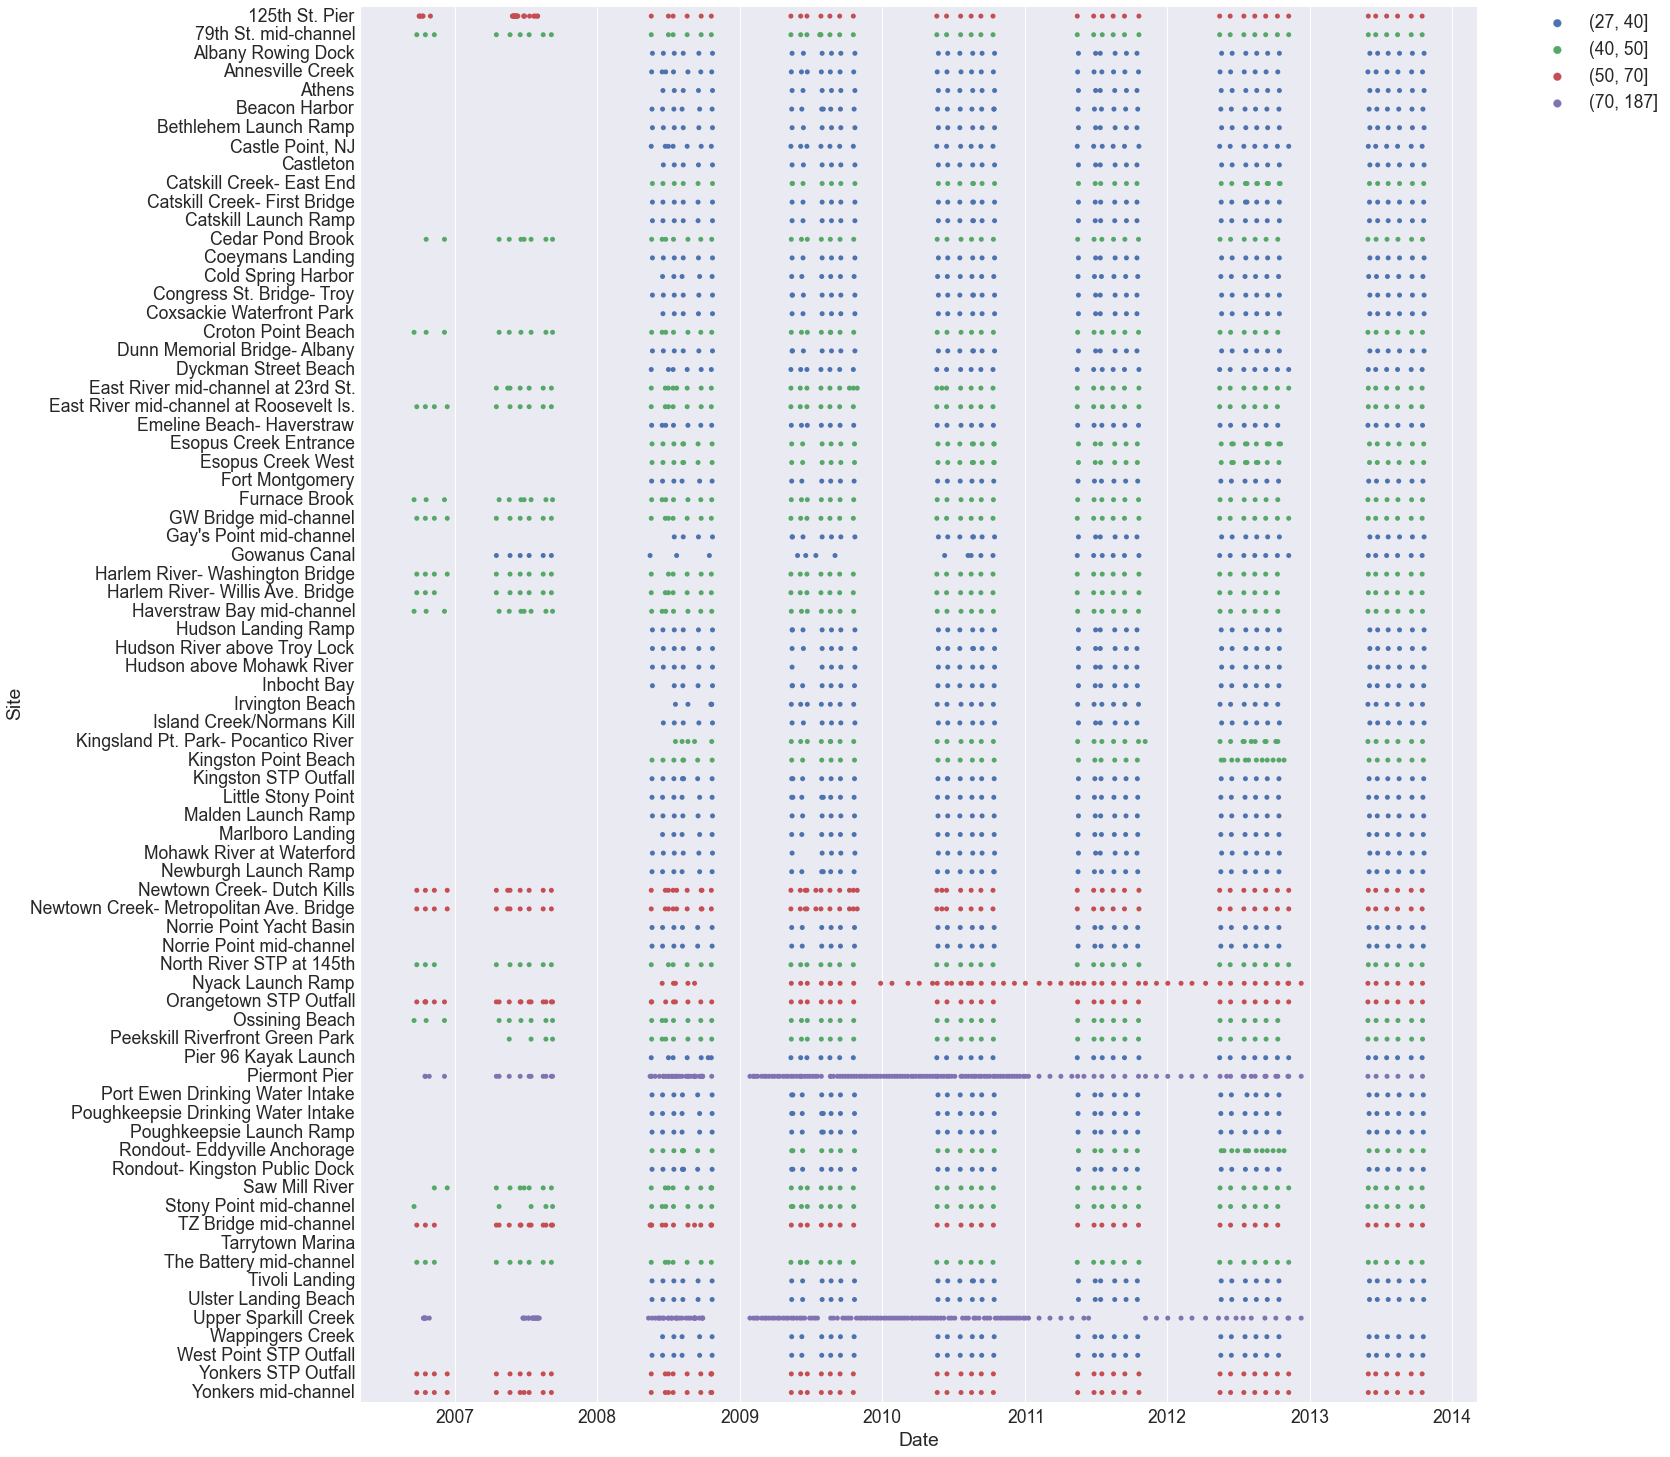

In [29]:
plt.figure(figsize=(20, 25))
sns.set(font_scale=1.75)

sns.stripplot(x="Date", y="Site", hue='SampleCount', data=rk_bins, jitter=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This strip plot shows that some sites are monitored almost continuously, but most samples com on a monthly basis and only during the late spring through autumn months. Less than half the sites were monitored back to 2006, but the entire site set has been monitored since 2008. 

#### 3. Is there a relationship between the amount of rain and water quality?  Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.

Enterococcus is often associated with high rain events in cities which have combine sewer overflow (CSO) systems. These sewer systems treat all rain water that flows into the storm drains at a wastewater treatment plan up to a certain capacity - storm water and sewage system flow beyond that capacity is dumped into the recieving waterbody without treatment.

This means that Entero and other indicators of untreated human feces are often punctuated by high levels after rainstorm events, with more acceptable baseline levels.  

First, I looked at the all the sites in agggregate:


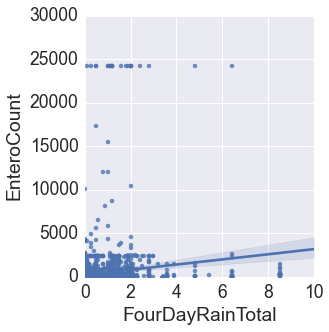

In [30]:
g3a = sns.lmplot('FourDayRainTotal', 'EnteroCount', rk)
g3a = g3a.set(ylim=(0, None), xlim=(0, None))

In aggregate, there is a weak relationship between the previous four day rain total and Enterococci counts. 

Viewing the dataset site by site:

Using lmplot allows the automatic addition of a linear model. 

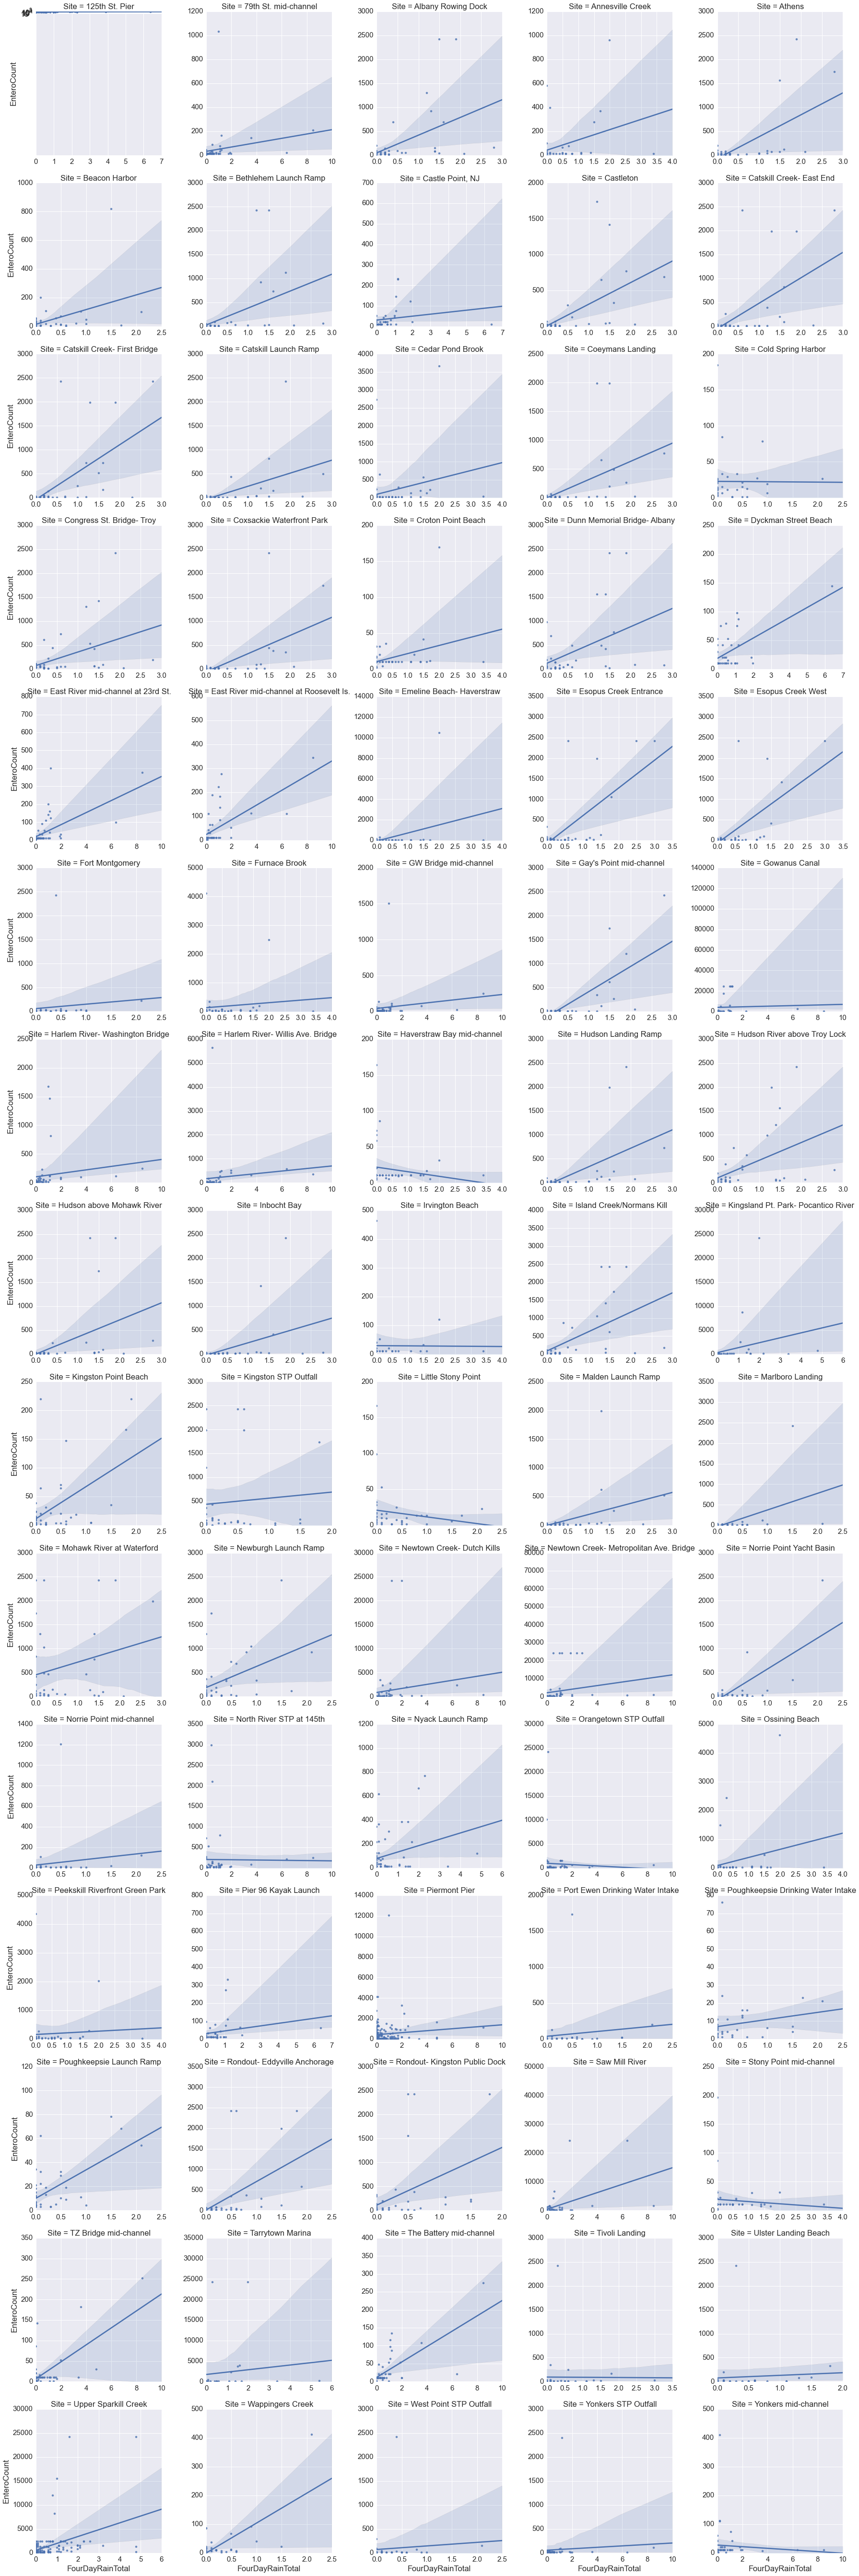

In [31]:
with sns.plotting_context('notebook', font_scale=1.5):
    g3 = sns.lmplot('FourDayRainTotal', 'EnteroCount', rk, col='Site', col_wrap = 5, sharex=False, sharey=False)

    g3 = g3.set(ylim=(0, None), xlim=(0, None))

    g3 = g3.fig.get_axes()[0].set_yscale('log')
    sns.set(font_scale=0.8)
    plt.show()

Generally, higher rainfall is associated with higher Enterococci counts. However, the realtionship does not exist at each site and is fairly weak.

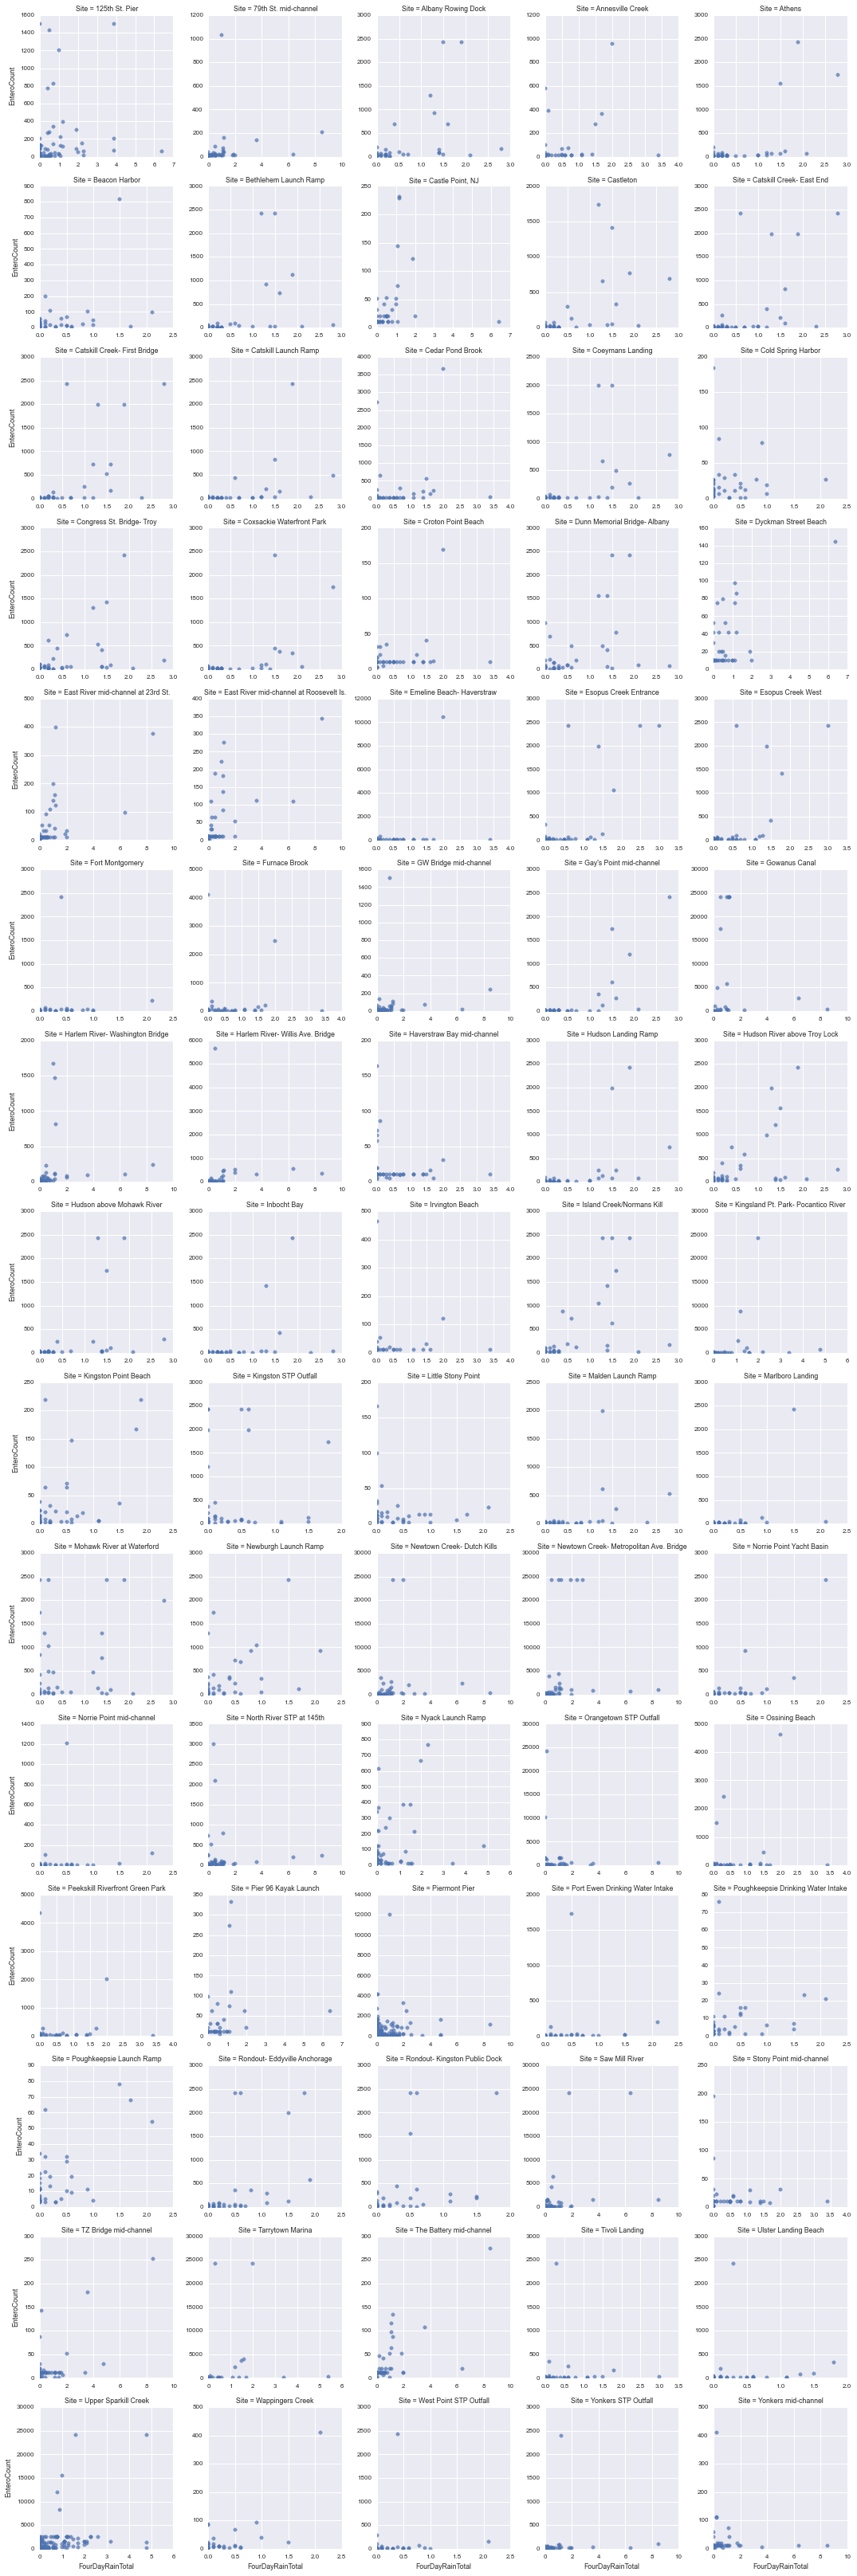

In [32]:
# first attempt
# here I pass the matplotlib scatter method to FacetGrid. This makes for a nice, easy to read set of charts. 
# however, I coundn't figure out how to add any sort of model 

sns.set(font_scale=0.8)
g3 = sns.FacetGrid(rk, col="Site", col_wrap = 5, sharex=False, sharey=False)

g3 = g3.map(plt.scatter, "FourDayRainTotal", "EnteroCount", alpha=.7)

g3 = g3.set(ylim=(0, None), xlim=(0, None))


plt.show()